# Tarea 6. Redes generativas adversarias

1. Transforme el código de GAN-Mnist, para que quede todo escrito en clases (subclasing)

2.  Corra al menos 10 iteraciones en Colab o localmente y muestre resultados parciales en su informe

3. Realice un informe completo de la experiencia. 

## Importación de librerías  

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from IPython.display import clear_output
from IPython import display
import numpy as np
from tensorflow.keras.losses import BinaryCrossentropy
from zipfile import ZipFile
bce = BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Cargar y preparar el conjunto de datos

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normaliza las imágenes to [-1, 1]

- Se carga el conjunto de datos MNIST de números escritos a mano utilizando la biblioteca Keras de TensorFlow y lo divide en un conjunto de entrenamiento y un conjunto de prueba. El conjunto de datos consta de 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba.

  La función `load_data()` descarga el conjunto de datos MNIST de Internet si aún no se ha descargado y devuelve los datos como dos tuplas que contienen las imágenes y las etiquetas para el conjunto de entrenamiento y el conjunto de prueba, respectivamente.

  En este caso, la línea de código almacena el conjunto de entrenamiento de imágenes en la variable `train_images` y las etiquetas correspondientes en la variable `train_labels`. La línea de código utiliza también la convención de utilizar los guiones bajos `_` para las variables que no se utilizarán, ya que el conjunto de datos MNIST de prueba no se utilizará en este ejemplo.
  
- La segunda línea reformatea las imágenes de entrenamiento en tensores de 28 x 28 x 1, que se utilizan como entrada para el modelo de aprendizaje automático. También cambia el tipo de datos a float32 para que puedan manipularse adecuadamente.

- La tercera línea normaliza las imágenes para que los valores de píxeles estén en el rango de [-1, 1], lo que puede ayudar a mejorar el rendimiento del modelo de aprendizaje automático. Esto se hace restando 127.5 de cada valor de píxel y dividiendo por 127.5.

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Crea dataset. 
# Mezcla los datos  y construye lotes de datos
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

En esta línea de código, se está creando un objeto de tipo `tf.data.Dataset` que se utiliza para manejar y preprocesar los datos de entrenamiento. Los datos se cargan desde train_images, que es un arreglo de imágenes con dimensiones (número de imágenes, altura, ancho, canales). La función `shuffle` se utiliza para mezclar aleatoriamente los datos de entrenamiento y `BUFFER_SIZE` determina el tamaño del búfer de mezcla. La función `batch` se utiliza para agrupar las imágenes en lotes, con cada lote de tamaño `BATCH_SIZE`. El objeto `train_dataset` resultante se utiliza para alimentar el modelo de entrenamiento en el bucle de entrenamiento.

## Creación de clases

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()

        self.conv2 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()

        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)

    def call(self, x, training=True):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.leaky_relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.leaky_relu2(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

    def loss_fn(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

Esta es la implementación de la clase Discriminator, que es la red neuronal convolucional que se encarga de clasificar las imágenes generadas por el generador (clase Generator) como verdaderas o falsas.

El constructor de la clase define las capas convolucionales, de normalización y de activación necesarias para el modelo. La función `call()`  es la que se ejecuta cuando se llama al objeto de la clase Discriminator y se encarga de aplicar la red neuronal a la entrada que recibe.

La función `loss_fn()` se utiliza para calcular la función de pérdida que se utiliza para entrenar la red neuronal. Recibe como entrada la salida del Discriminator para imágenes reales y la salida para imágenes generadas por el Generator, y utiliza la función de entropía cruzada binaria para calcular la pérdida total.

In [ ]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense1 = tf.keras.layers.Dense(7*7*256, use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()

        self.reshape = tf.keras.layers.Reshape((7, 7, 256))

        self.conv1 = tf.keras.layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False,
                                                     kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False,
                                                     kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False,
                                                     kernel_initializer=tf.random_normal_initializer(stddev=0.02))

    def call(self, x, training=True):
        x = self.dense1(x)
        x = self.bn1(x, training=training)
        x = self.relu1(x)
        
        x = self.reshape(x)
        
        x = self.conv1(x)
        x = self.bn2(x, training=training)
        x = self.relu2(x)

        x = self.conv2(x)
        x = self.bn3(x, training=training)
        x = self.relu3(x)

        x = self.conv3(x)

        return x

    def loss_fn(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
noise = tf.random.normal([256, 100])
generator=Generator()
generated_images = generator.call(noise, training=True)

"Generator" y también hereda de la clase "tf.keras.Model". Esta clase representa el generador de la GAN, que es una red neuronal densa que recibe un vector de números aleatorios como entrada y produce una imagen falsa como salida. El generador tiene una capa densa, seguida de capas de normalización por lotes y funciones de activación ReLU. A continuación, tiene tres capas de convolución transpuesta para producir la imagen de salida. También define una función de pérdida que compara la salida del discriminador con una matriz de unos (ya que el objetivo del generador es engañar al discriminador para que crea que la imagen es real).

In [22]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator()
        self.generator = generator()
        self.latent_dim = latent_dim

        self.g_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.d_optimizer = tf.keras.optimizers.Adam(1e-4)

        self.d_loss_fn = self.discriminator.loss_fn
        self.g_loss_fn = self.generator.loss_fn

    def compile(self, metrics=None):
        super(GAN, self).compile(metrics=metrics)
   
    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([256, self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator.call(noise, training=True)

            real_output = self.discriminator.call(images, training=True)
            fake_output = self.discriminator.call(generated_images, training=True)

            gen_loss = self.g_loss_fn(fake_output)
            disc_loss = self.d_loss_fn(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {
            'gen_loss': gen_loss,
            'disc_loss': disc_loss
        }
    
    
    def generate_and_show_images(self, epoch, seed):
        # Generar imágenes falsas
        predictions = self.generator(seed, training=False)

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        plt.show()
    
    def train(self, dataset, epochs):
        seed = tf.random.normal([16, self.latent_dim])  # Generar semilla de ruido para generar imágenes

        for epoch in range(epochs):
            start = time.time()

            for image_batch in dataset:
                self.train_step(image_batch)
           
            display.clear_output(wait=True)
            self.generate_and_show_images(epoch + 1, seed)


            # Generar imágenes al final de la época
            if (epoch + 1) % 5 == 0:
                print('El tiempo de la época {} es {} segundos'.format(epoch + 1, time.time() - start))

    

Este es un modelo GAN (Generative Adversarial Network) que utiliza un discriminador y un generador. El discriminador toma una imagen y la clasifica como real o falsa, mientras que el generador toma un vector de ruido aleatorio y genera una imagen falsa. El objetivo de la red GAN es entrenar al generador para que genere imágenes que engañen al discriminador haciéndolo pensar que son imágenes reales.

El método `compile` se utiliza para definir el optimizador y la función de pérdida de la red. El método `train_step` es donde se realiza el entrenamiento, tomando un lote de imágenes reales, generando un conjunto de imágenes falsas y ajustando los pesos del discriminador y del generador en consecuencia. El método `generate_and_show_images` se utiliza para generar imágenes a medida que la red está siendo entrenada. Finalmente, el método `train` se utiliza para entrenar la red para un número específico de épocas.

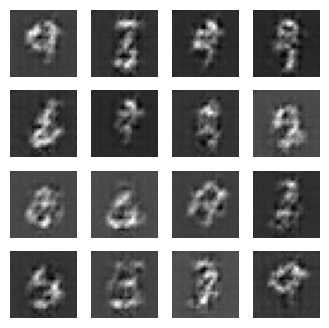

El tiempo de la época 10 es 124.21350193023682 segundos


In [23]:
gan = GAN(discriminator=Discriminator, generator=Generator, latent_dim=100)
gan.compile()
gan.train(train_dataset, epochs=10)

Podemos observar que a medida que transcurren las épocas, el generador va mejorando progresivamente su capacidad para generar imágenes que se asemejan cada vez más a las originales. Como resultado, llegará un punto en el que las imágenes generadas por el generador serán extremadamente similares a las imágenes reales, dificultando su distinción a simple vista. Esto implica que el generador ha aprendido a capturar las características esenciales de las imágenes y a reproducirlas de manera convincente. Sin embargo, el discriminador también se entrena simultáneamente para ser más hábil en la detección de imágenes falsas, lo que asegura un proceso de mejora continua en la calidad de las imágenes generadas